<a href="https://colab.research.google.com/github/ManthanShettigar/SamosaBurger-CNN-Classifier/blob/master/Food_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Food Classifier


## Load and prepare Data

docker build -t burger_samosa_classifier . && docker run --rm -it -p 5000:5000 burger_samosa_classifier


First we need to update the notebook to the latest version of fastai.

In [ ]:
!pip install -Uqq fastai 
from fastai.vision.all import *

At first we are downloading the Food Dataset, containing about 100k images of various kind of foods.
Documentation for all Datasets: https://docs.fast.ai/data.external

In [ ]:
foodPath = untar_data(URLs.FOOD)

In [ ]:
foodPath

Path('/root/.fastai/data/food-101')

In [ ]:
#How many images are we dealing with
len(get_image_files(foodPath))

101000

In [ ]:
#lets read the data 
pd.read_json('/root/.fastai/data/food-101/test.json')

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,tacos,pad_thai,poutine,ramen,pulled_pork_sandwich,bibimbap,beignets,apple_pie,crab_cakes,risotto,paella,steak,baby_back_ribs,miso_soup,frozen_yogurt,club_sandwich,carrot_cake,falafel,bread_pudding,chicken_wings,gnocchi,caprese_salad,creme_brulee,escargots,chocolate_cake,tiramisu,spaghetti_bolognese,mussels,scallops,baklava,...,fried_rice,donuts,gyoza,ravioli,fried_calamari,spaghetti_carbonara,french_toast,lobster_bisque,ceviche,bruschetta,french_fries,shrimp_and_grits,filet_mignon,hamburger,dumplings,tuna_tartare,sushi,cheese_plate,eggs_benedict,cup_cakes,takoyaki,chocolate_mousse,breakfast_burrito,hot_dog,macarons,waffles,seaweed_salad,cannoli,huevos_rancheros,pizza,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1061830,hot_and_sour_soup/1000486,samosa/1009326,sashimi/100113,pork_chop/1012227,spring_rolls/1005480,panna_cotta/1006650,beef_tartare/101073,greek_salad/1010850,foie_gras/1007306,tacos/1023947,pad_thai/1081901,poutine/1000631,ramen/1000325,pulled_pork_sandwich/1027491,bibimbap/1001113,beignets/1002850,apple_pie/1011328,crab_cakes/1003337,risotto/1004935,paella/1019711,steak/100274,baby_back_ribs/1005066,miso_soup/1014272,frozen_yogurt/1012504,club_sandwich/1018254,carrot_cake/1006961,falafel/102356,bread_pudding/1005036,chicken_wings/1010547,gnocchi/1005096,caprese_salad/1012384,creme_brulee/1007951,escargots/1007283,chocolate_cake/1033790,tiramisu/1009109,spaghetti_bolognese/1027299,mussels/1009170,scallops/100757,baklava/1028777,...,fried_rice/1023430,donuts/1006079,gyoza/1009005,ravioli/100904,fried_calamari/1007131,spaghetti_carbonara/1003992,french_toast/100864,lobster_bisque/1003421,ceviche/102574,bruschetta/1013211,french_fries/1008163,shrimp_and_grits/1011384,filet_mignon/1023857,hamburger/1010136,dumplings/1016850,tuna_tartare/1008604,sushi/101625,cheese_plate/1011471,eggs_benedict/1013425,cup_cakes/1003128,takoyaki/1002013,chocolate_mousse/1002682,breakfast_burrito/1000920,hot_dog/103364,macarons/1005656,waffles/1005755,seaweed_salad/1004774,cannoli/1087676,huevos_rancheros/1010595,pizza/1001116,chicken_quesadilla/10257,pho/1002382,prime_rib/1006976,cheesecake/1023543,ice_cream/1004744,omelette/1019294,grilled_cheese_sandwich/1000938,lobster_roll_sandwich/1002698,nachos/1011831,oysters/1005672
1,churros/1064042,hot_and_sour_soup/1004564,samosa/1024186,sashimi/1017182,pork_chop/1019077,spring_rolls/103010,panna_cotta/1027460,beef_tartare/1029120,greek_salad/1029680,foie_gras/1044237,tacos/1026681,pad_thai/1097554,poutine/1008948,ramen/1006057,pulled_pork_sandwich/103159,bibimbap/1004374,beignets/1017820,apple_pie/101251,crab_cakes/1005068,risotto/1035813,paella/1026685,steak/1012080,baby_back_ribs/1022479,miso_soup/1023581,frozen_yogurt/1068965,club_sandwich/1029932,carrot_cake/1007814,falafel/102549,bread_pudding/1042213,chicken_wings/1022035,gnocchi/1006467,caprese_salad/1020090,creme_brulee/1008540,escargots/1020422,chocolate_cake/1043216,tiramisu/1016527,spaghetti_bolognese/1043568,mussels/1032631,scallops/100959,baklava/1029051,...,fried_rice/1028159,donuts/1007399,gyoza/1026798,ravioli/1027063,fried_calamari/1016491,spaghetti_carbonara/10053,french_toast/1008722,lobster_bisque/1008682,ceviche/1030519,bruschetta/1018048,french_fries/1033213,shrimp_and_grits/1017959,filet_mignon/103497,hamburger/1031616,dumplings/1032706,tuna_tartare/101560,sushi/1016390,cheese_plate/101176,eggs_benedict/1039716,cup_cakes/1008028,takoyaki/1010258,chocolate_mousse/1008451,breakfast_burrito/1015606,hot_dog/10464,macarons/1027142,waffles/102624,seaweed_salad/1008972,cannoli/109727,huevos_rancheros/1017765,pizza/1032754,chicken_quesadilla/1030292,pho/1020153,prime_rib/102197,cheesecake/102854,ice_cream/1031536,omelette/1058816,grilled_cheese_sandwich/1003050,lobster_roll_sandwich/1029665,nachos/101954,oysters/1017801
2,churros/1

In [ ]:
#Deciding which two foods we want to classify
labelA = 'samosa'
labelB = 'hamburger'

In [ ]:
get_image_files(foodPath)

(#101000) [Path('/root/.fastai/data/food-101/images/bibimbap/36020.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/3752972.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/1395464.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/3596263.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/1939877.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/1733028.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/2662305.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/3187646.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/1080890.jpg'),Path('/root/.fastai/data/food-101/images/bibimbap/739355.jpg')...]

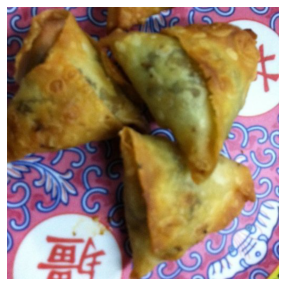

In [ ]:
#lets see how a samosa looks like 
img1 = PILImage.create('/root/.fastai/data/food-101/images/samosa/1009326.jpg')
img1.show()

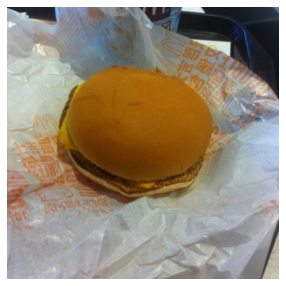

In [ ]:
#lets see how a hamburger looks like 
img2 =PILImage.create('/root/.fastai/data/food-101/images/hamburger/950766.jpg')
img2.show()

**Some Data Preperation**

Next we're gonna do some preperation to make the data handling easier. It's not important that you understand the following code snippet completly.

We're just doing two things:


1.   Removing all images that don't have labelA or labelB
2.   Renaming images with labelA or labelB to have that label in their filename



In [ ]:
#Loop through all Images downloaded
for img in get_image_files(foodPath):    
  #Rename Images so that the Label (Samosa or Burger) is in the file name
  if labelA in str(img):
    img.rename(f"{img.parent}/{labelA}-{img.name}")
  elif labelB in str(img):
    img.rename(f"{img.parent}/{labelB}-{img.name}")
  else: os.remove(img) #If the Images are not part of labelA or labelB

len(get_image_files(foodPath))

2000

## Train Model

In [ ]:
def GetLabel(fileName):
  return fileName.split('-')[0]

GetLabel("samosa-1009326.jpg") #Testing

'samosa'

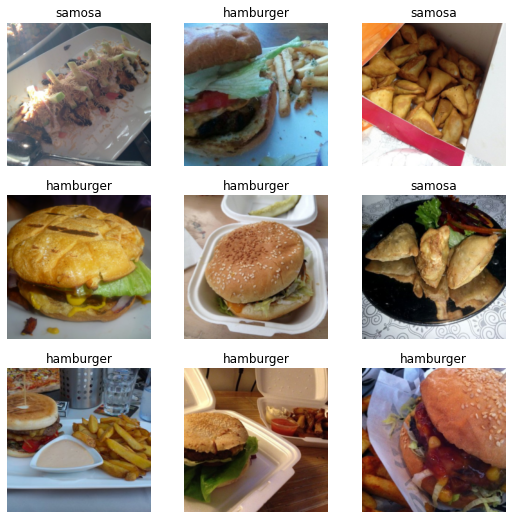

In [ ]:
dls = ImageDataLoaders.from_name_func(
    foodPath, get_image_files(foodPath), valid_pct=0.2, seed=420,
    label_func=GetLabel, item_tfms=Resize(224))

dls.train.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(epochs=10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.566109,0.169717,0.055000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.204727,0.114508,0.040000,00:14
1,0.120723,0.109441,0.032500,00:13
2,0.075827,0.117126,0.037500,00:13
3,0.053609,0.124477,0.037500,00:14
4,0.037470,0.073175,0.027500,00:13
5,0.025555,0.083794,0.032500,00:13
6,0.017379,0.104498,0.032500,00:13
7,0.013140,0.082841,0.020000,00:14
8,0.008515,0.080080,0.020000,00:13
9,0.005759,0.081568,0.020000,00:14


## Verify Model

### Upload your own Images

Saving 1.jpg to 1 (1).jpg


This is a samosa.
samosa 1.000000
hamburger 0.000000


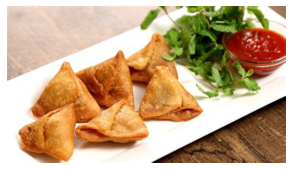

In [ ]:
from google.colab import files
uploader = files.upload()

for img in uploader.items():
  uploadedImg = img[0]

img = PILImage.create(uploadedImg)
img.show()

label,_,probs = learn.predict(img)

print(f"This is a {label}.")
print(f"{labelA} {probs[1].item():.6f}")
print(f"{labelB} {probs[0].item():.6f}")

### Test using images in dataset

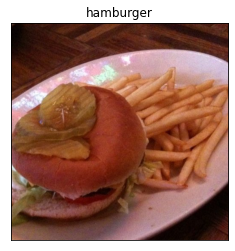

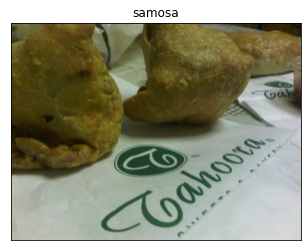

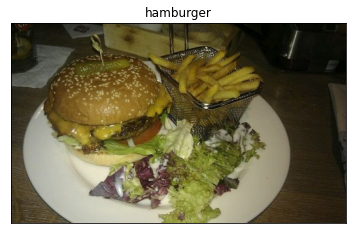

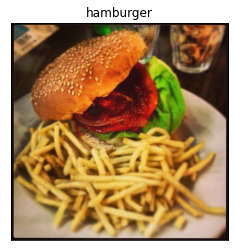

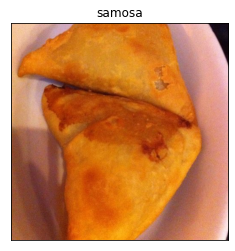

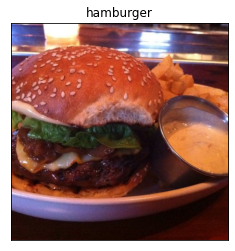

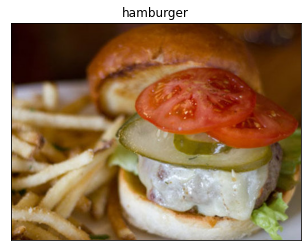

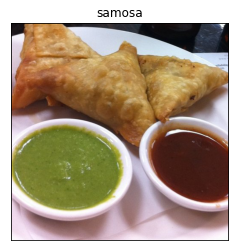

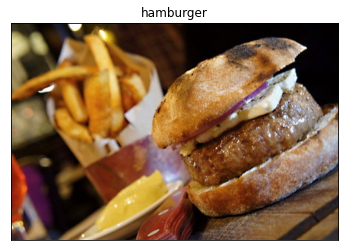

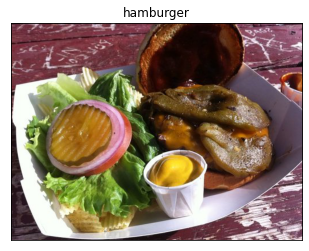

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(0,10):
  #Load random image
  randomIndex = random.randint(0, len(get_image_files(foodPath))-1)
  img = mpimg.imread(get_image_files(foodPath)[randomIndex])
  #Put into Model
  label,_,probs = learn.predict(img)

  #Create Figure using Matplotlib
  fig = plt.figure()
  ax = fig.add_subplot() #Add Subplot (For multiple images)
  imgplot = plt.imshow(img) #Add Image into Plot
  ax.set_title(label) #Set Headline to predicted label

  #Hide numbers on axes
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)

### Confusion Matrix (optional)

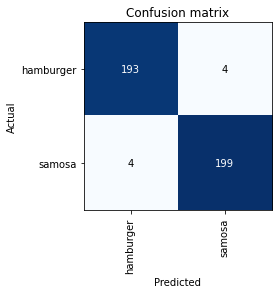

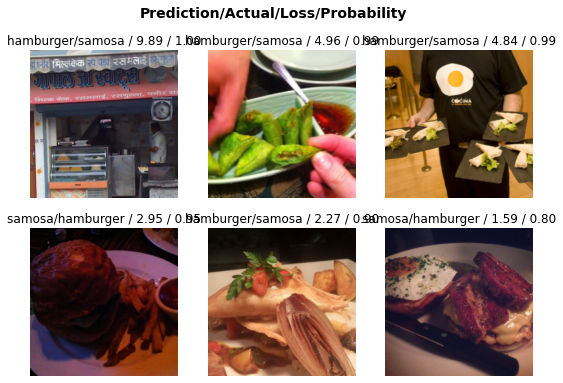

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(6)

## Deploy

In [ ]:
learn.export() #exports model as 'export.pkl' by default

In [ ]:
#let's grab the first pkl file we can find
modelPath = get_files(foodPath, '.pkl')[0]
modelPath

Path('/root/.fastai/data/food-101/export.pkl')

In [ ]:
learn_inf = load_learner(modelPath)
learn_inf.predict(mpimg.imread(get_image_files(foodPath)[0])) #raw prediction

('hamburger', tensor(0), tensor([1.0000e+00, 2.3063e-08]))

In [ ]:
learn_inf.dls.vocab #Get the labels

['hamburger', 'samosa']

In [ ]:

from google.colab import files
files.download(modelPath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>